# Banpei Anomaly/Outlier Detection
*Written by HMC Clinic, 2021 for Mee Panyar*

The algorithms included in the Banpei anomaly detection library are:
    
    - Hotelling's Method (Outlier Detection)
    - Singular Spectrum Analysis (Anomaly Detection)

Both of these algorithms are implemented in the code below. This library has been forked from its original to better fit Mee Panyar's usage.

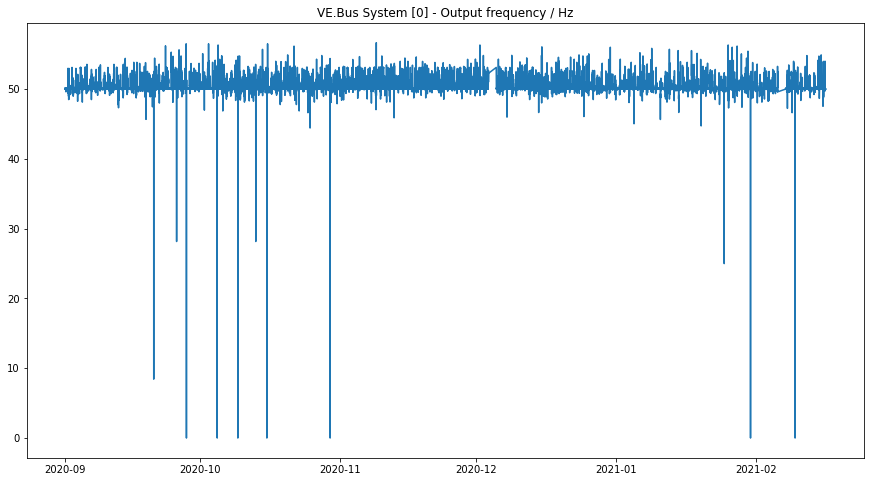

In [1]:
import banpei
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Choose a filename of interest
filename = 'data_cleaned_022421.csv'
data = pd.read_csv(filename)

# Select the column of interest - Battery SOC
column = 'VE.Bus System [0] - Output frequency / Hz'
downsample = 15 # downsample rate

np_data = np.array(data[column])
np_data = np_data[::downsample]

# Get the corresponding timestamps
time = np.array(data['Timestamp'])
time = time[::downsample]
time = np.array(pd.to_datetime(time.tolist()))

# Visualize the raw data
fig, ax = plt.subplots(1,figsize=(15,8))
ax.plot_date(time, np_data, xdate=True, fmt='-')
ax.title.set_text(column)
plt.show()

## Hotelling's Method
Hotelling's method is a statistical outlier detection algorithm that is effective at flagging when a dataset begins returning values that are too high or too low.  The algorithm works as follows:

1. A user passes a numpy array and a threshold. This value corresponds to the cdf value of the $\chi^2$ distribution at which to establish a cuttoff. A smaller value is less sensitive as the desired area is caluclated 1-threshold.
2. The dataset is replaced by its own z-score.
3. Z-scores greater than the $\chi^2$ distribution cutoff are considered anomalies.

Some problems with this is that it effectively assumes that each instance is independently normally distributed (such that $\chi^2$ applies) and that the parameters of mean and standard deviation over the entire set make sense. 

The mean and standard deviation must be trained on known good functioning sets and then transfered as constants to a live version.

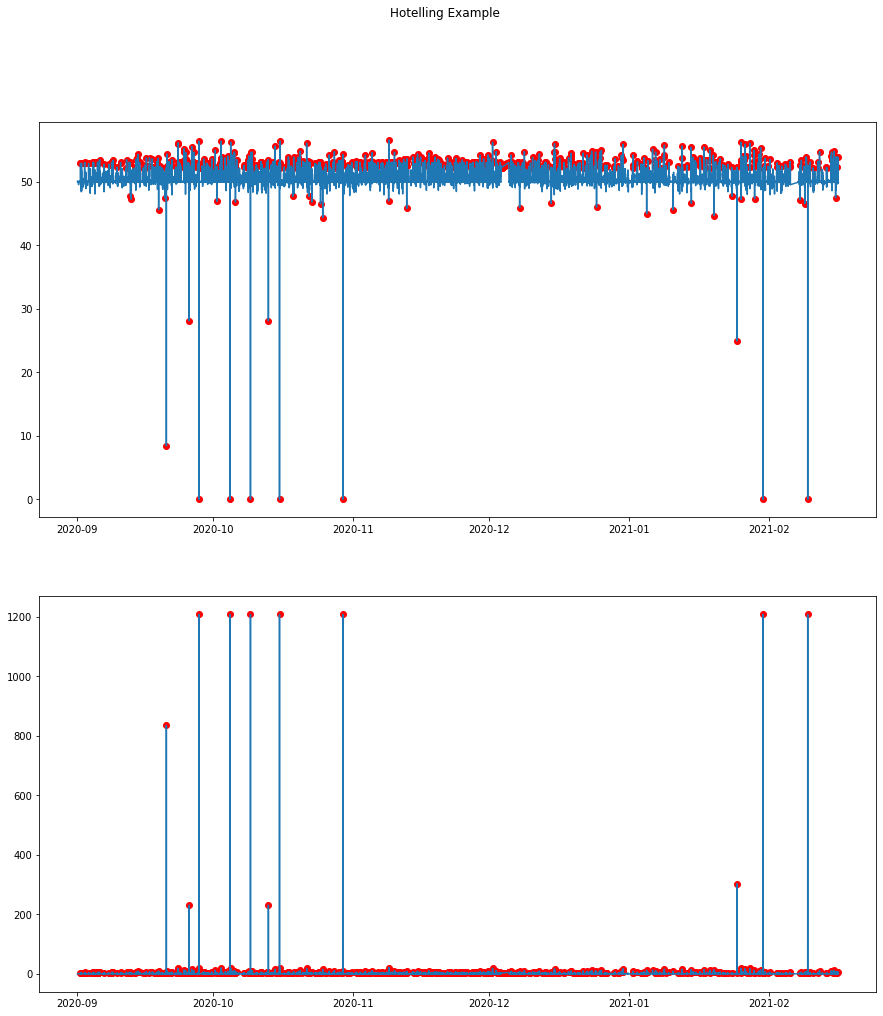

In [15]:
# Create model
model = banpei.Hotelling()

# Define Parameters
threshold = 0.25
trained_mean = 50
trained_var = 2.07

results = model.detect(np_data, threshold, trained_mean, trained_var)

# Gather anomalies for easy plotting
binary_mark = results[:,1]
time_results = []
outlier_data = []
outlier_res  = []
for i in range(len(binary_mark)):
    if binary_mark[i] == 1: # anomaly detected
        time_results.append(time[i])
        outlier_data.append(np_data[i])
        outlier_res.append(results[i,0])

# Visualize the results
fig, axs = plt.subplots(2,figsize=(15,16))
fig.suptitle('Hotelling Example')
axs[0].plot_date(time, np_data, xdate=True, fmt='-')
axs[0].scatter(time_results, outlier_data, c='red')
axs[1].plot_date(time, results[:,0], xdate=True, fmt='-')
axs[1].scatter(time_results, outlier_res, c='red')
plt.show()

## Singular Spectrum Analysis
Singular spectrum analysis (SSA) is a non-parametric spectral estimation method that combines classical time series analysis, multivariate statistics, and signal processing. SSA has its roots in the KLT transform. SSA decomposes a time series into a sum of components such at each component has a meaningful interpretation.

The name "singular spectrum" relates to the spectrum of eigenvalues in a singular value decomposition of a covariance matrix. Therefore, SSA is not directly related to frequecy domain decomposition.

SSA can be effectively used as a non-parametric method of time series monitoring in order to detect changes. This works as follows:

SSA is applied sequenctially to the intial parts of the time series.
A distance is measured between the signal subspaces and the lagged vectors formed by the few most recent observations.
If these distance become too large, a structural change is likely.

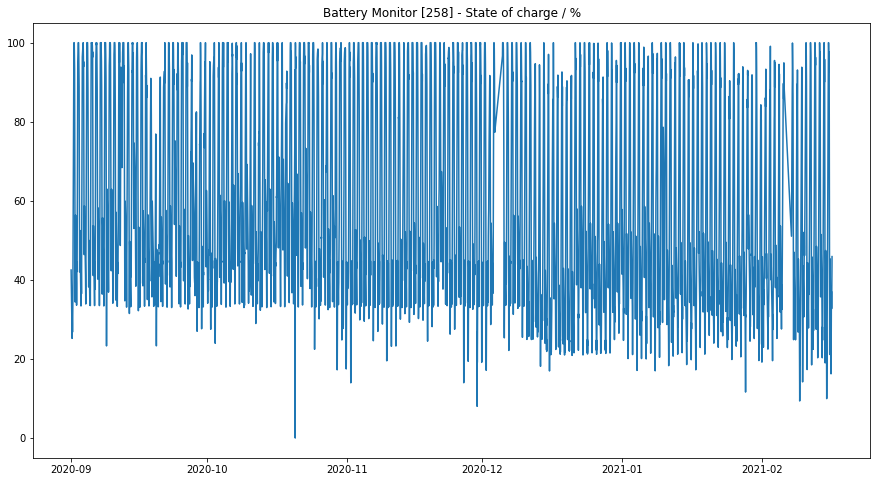

In [17]:
# Get the data that we want
column = 'Battery Monitor [258] - State of charge / %'
downsample = 15 # downsample rate
np_data = np.array(data[column])
np_data = np_data[::downsample]

# Visualize the dataset
fig, ax = plt.subplots(1,figsize=(15,8))
ax.plot_date(time, np_data, xdate=True, fmt='-')
ax.title.set_text(column)
plt.show()

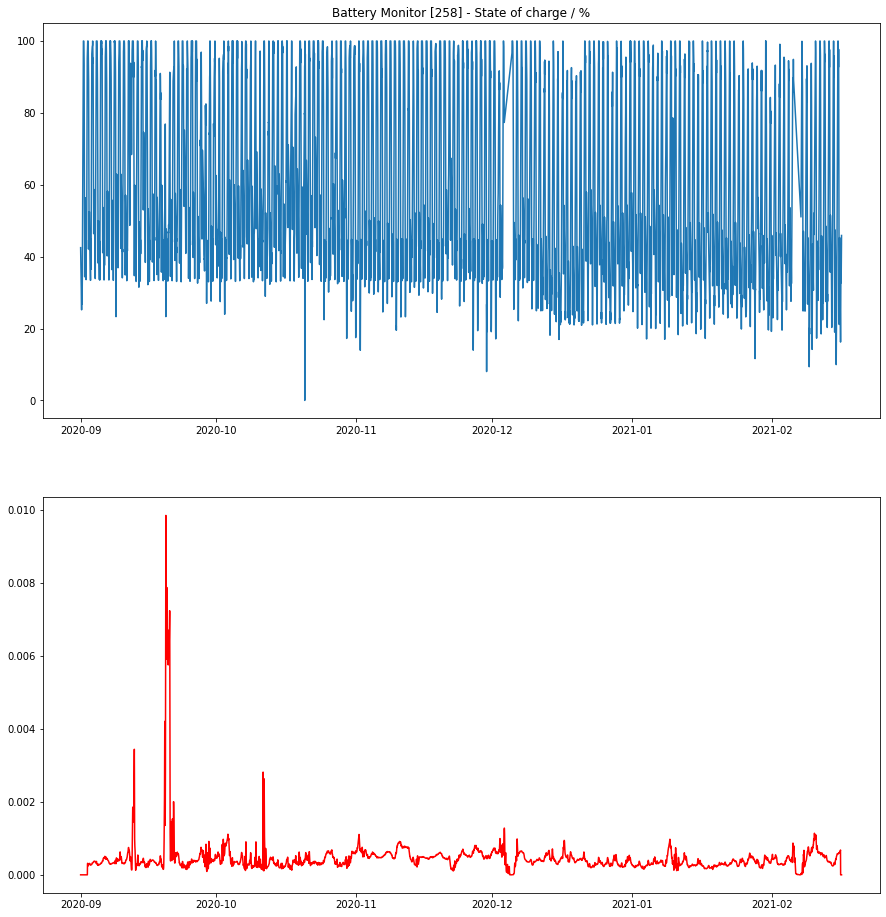

In [20]:
window = 96
model = banpei.SST(w=window)
results = model.detect(np_data,is_lanczos=False)

# Visualize
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,16))
ax1.plot_date(time, np_data, xdate=True, fmt='-')
ax1.title.set_text(column)
ax2.plot_date(time, results, xdate=True, fmt='-', color='red')
plt.show()

## Threshold Selection
It may be useful to visualize the data cumulatively in order to select a percentage threshold for a decision boundary. The following functions implement a cumulative results distribution visualization so that an engineer may select an apporpriate threshold for the above SSA implementation.

In [21]:
def find_cutoff_ratio(data, ratio, is_sorted=False):
    """Given a datastream and ratio, returns a cutoff to achieve ratio kept
    Parameters:
        data       -- numpy array containing datastream
        ratio      -- float containing the intended approximate ratio i.e. 0.05 = upper 5% are outliers
        is_sorted  -- bool indicating if the data is sorted from least to greatest or not
    Returns:
        cutoff     -- cutoff value to ensure the ratio of data is below
        
    ## I don't like this method very much because it relies on value within the data itself
    ## better to assess the cumulative plot below
    """
    if is_sorted:
        sorted_data = data
    else:
        sorted_data = np.sort(data)
        
    idx = np.floor(data.size * (1-ratio))
    cutoff = sorted_data[idx]
    return cutoff

def plot_cutoff_ratio(data):
    """Given a datastream, plots the amount of data below a cutoff range by normalizing between 0-1
    Parameters:
        data       -- numpy array containing datastream
    """
    normalized_data = data / np.max(data)
    n_data = len(data)
    test_range = np.linspace(0,1,num=101)
    ratio_list = []
    for i in test_range:
        n_less = len(np.where(normalized_data < i)[0])
        ratio = n_less / n_data # at the given cutoff - the amount of non-anomalous data
        ratio_list.extend([ratio])
    ratio_list = np.array(ratio_list)
    
    plt.subplots(1,figsize=(15,8))
    plt.plot(test_range*np.max(data), ratio_list)
    plt.title('Cumulative Data Distribution')
    plt.xlabel('Cutoff')
    plt.ylabel('% of Non Amomalous Data')
    plt.show()
    return ratio_list, test_range*np.max(data)

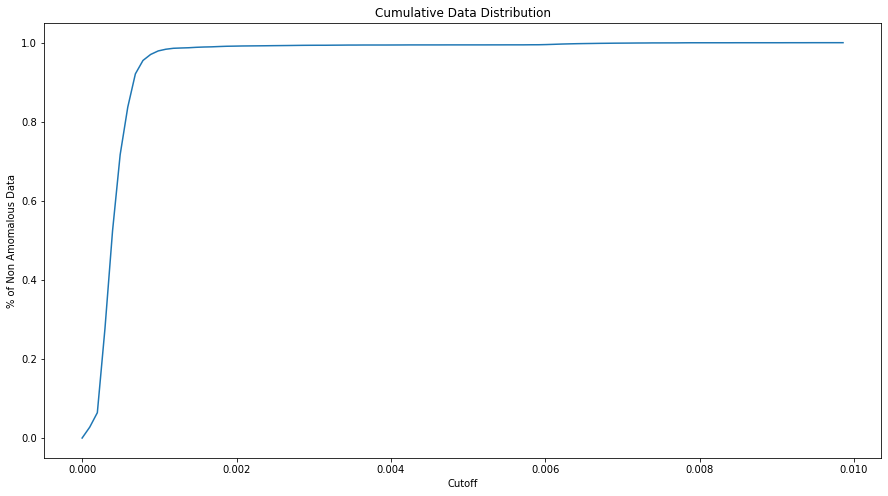

In [22]:
ratio_list, test_range = plot_cutoff_ratio(results)

Based on the above chart it should be straightforward to select an appropriate cutoff. Once such a value is selected, it can be assessed below visually and returning expected outliers/changepoints. The choice of a cutoff will change the strength of this detector.

0.0017464179867037676


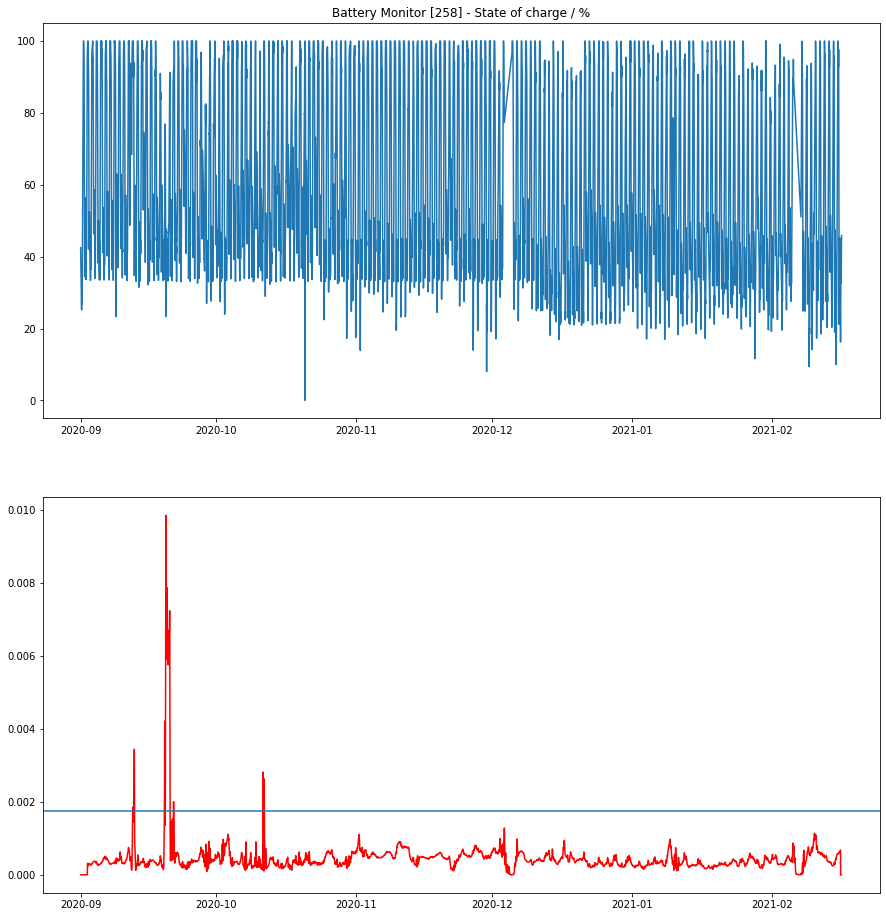

In [24]:
percent_anom = 0.99
cutoff_interp = np.interp([percent_anom], ratio_list, test_range)
cutoff_interp = cutoff_interp[0]
print(cutoff_interp)

cutoff = cutoff_interp
###################################################################

fig, (ax1, ax2) = plt.subplots(2,figsize=(15,16))
ax1.plot_date(time, np_data, xdate=True, fmt='-')
ax1.title.set_text(column)
ax2.plot_date(time, results, xdate=True, fmt='-', color='red')
ax2.axhline(cutoff)
plt.show()

In [25]:
# Get the timestamps that are anomalous and print them to the console
idx = np.where(results > cutoff)[0]
timestamps = time[idx]

print('Anomalous timestamps:\n')
for i in range(len(timestamps)):
    print(timestamps[i])

Anomalous timestamps:

2020-09-12T12:15:00.000000000
2020-09-12T12:30:00.000000000
2020-09-12T12:45:00.000000000
2020-09-12T13:00:00.000000000
2020-09-12T13:15:00.000000000
2020-09-12T13:30:00.000000000
2020-09-12T13:45:00.000000000
2020-09-12T14:00:00.000000000
2020-09-12T18:15:00.000000000
2020-09-12T18:30:00.000000000
2020-09-12T18:45:00.000000000
2020-09-12T19:00:00.000000000
2020-09-12T19:15:00.000000000
2020-09-12T19:30:00.000000000
2020-09-12T19:45:00.000000000
2020-09-12T20:00:00.000000000
2020-09-12T20:15:00.000000000
2020-09-12T20:30:00.000000000
2020-09-12T20:45:00.000000000
2020-09-12T21:00:00.000000000
2020-09-12T21:15:00.000000000
2020-09-12T21:30:00.000000000
2020-09-12T21:45:00.000000000
2020-09-12T22:00:00.000000000
2020-09-12T22:15:00.000000000
2020-09-19T13:15:00.000000000
2020-09-19T13:30:00.000000000
2020-09-19T13:45:00.000000000
2020-09-19T14:00:00.000000000
2020-09-19T14:15:00.000000000
2020-09-19T14:30:00.000000000
2020-09-19T14:45:00.000000000
2020-09-19T15:00: